In [6]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join, basename
import pickle
from scipy.stats import pearsonr
from scipy.signal import periodogram, filtfilt
import seaborn as sns
from tqdm import tqdm

from filtering import freq_filt

banner_coords = (44.3, -115.233)
res = pd.read_csv('/bsuscratch/zacharykeskinen/data/infrasound/eq_catalog/selected_v2.csv')
from shapely import wkt
res['geometry'] = res['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(res, geometry = 'geometry', crs = 'EPSG:4326')

result_dir = '/bsuscratch/zacharykeskinen/data/infrasound/psd_results'
data_dir = '/bsuscratch/zacharykeskinen/data/infrasound/array_data'
with open(join(data_dir, 'merged/all_days'), 'rb') as f:
    days = pickle.load(f)
sps = 200

In [ ]:
sns.set(font='sans-serif',
        rc={
 'axes.axisbelow': True,
 'axes.edgecolor': 'grey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.grid.axis':'y',
 'axes.labelcolor': 'black',
 'axes.linewidth': 1,
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'lightgrey',
 'figure.figsize': (18, 12),
 'font.family':'Arial',
 'grid.color': 'grey',
 'grid.alpha':1,
 'grid.linewidth':0.5,
 'image.aspect':'auto',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'savefig.dpi':300,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'grey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'grey',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.color':'grey',
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":26,
                                "axes.labelsize":16})

 16%|█▌        | 15/94 [00:10<01:06,  1.19it/s]

2022-03-20
The length of the input vector x must be greater than padlen, which is 9.


100%|██████████| 94/94 [04:15<00:00,  2.72s/it]


TypeError: savefig() takes 2 positional arguments but 3 were given

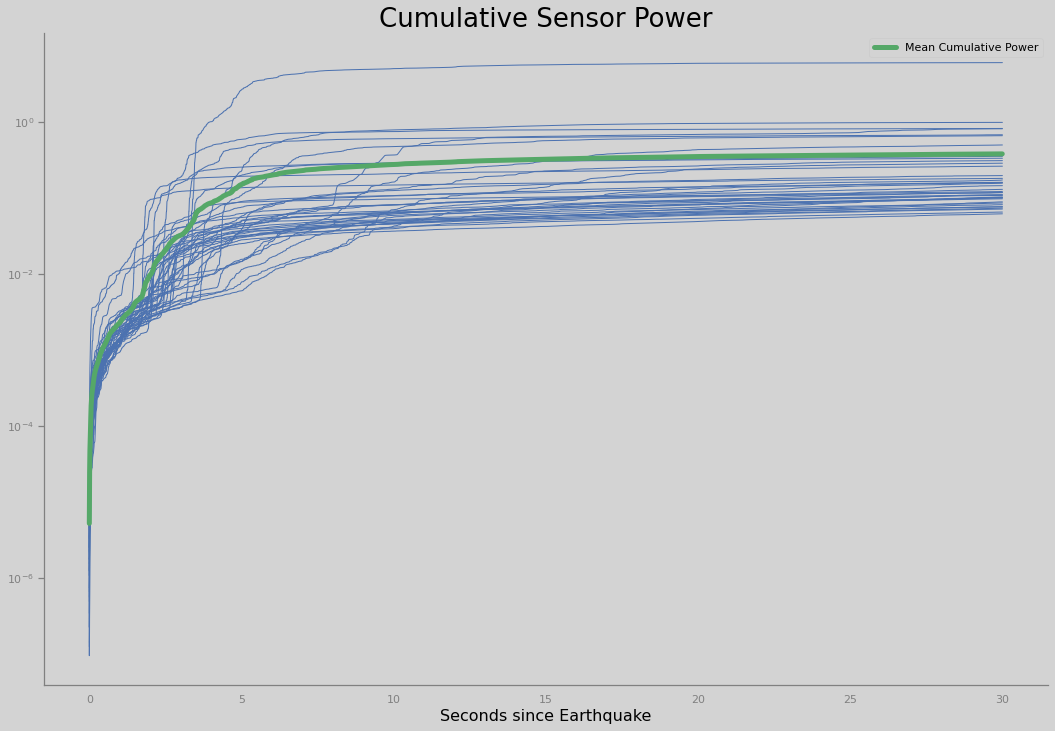

In [53]:
f, ax = plt.subplots(facecolor = 'lightgrey')
ss = []
ps = []
for i, r in tqdm(res[res.selected == 1].iterrows(), total = len(res[res.selected == 1])):
    dt = pd.to_datetime(r.time).strftime('%Y-%m-%d')
    day = days[dt]
    sig = {}
    psig = {}
    s = pd.to_datetime(r.time) + pd.Timedelta('0 second')
    e = s + pd.Timedelta('30 second')
    pres = s - pd.Timedelta('30 seconds')

    try:
        if 0.33 in day.keys() and 1.33 in day.keys() and day['snotel']['Snow Depth (cm) Start of Day Values'] > 133:
            for name, fp in day.items():
                if name != 'snotel' and name != 2:
                    par = pd.read_parquet(fp)
                    sig[name] = freq_filt(par[s:e].values.ravel(), 1, kind = 'highpass')
                    psig[name] = freq_filt(par[pres:s].values.ravel(), 1, kind = 'highpass')
            df = pd.DataFrame(sig)
            pre_df = pd.DataFrame(psig)
            ave_pow = np.cumsum(df.mean(axis = 1)**2)
            pre_pow = np.cumsum(pre_df.mean(axis = 1)**2)
            ss.append(ave_pow)
            ps.append(pre_pow)
            sns.lineplot(x = np.linspace(0, 30, len(df)), y = ave_pow, ax = ax, color = 'C0', linewidth = 1)
            # ave_pow.plot(ax = ax)
    except ValueError as e:
        print(dt)
        print(e)

r = ss[0]
for i, s in enumerate(ss):
    if i != 0:
        r = r + s
r = r/len(ss)
sns.lineplot(x = np.linspace(0, 30, len(df)), y = r, ax = ax, color = 'C2', linewidth = 5, label = 'Mean Cumulative Power')
plt.yscale('log')
plt.title('Cumulative Sensor Power')
plt.xlabel('Seconds since Earthquake')

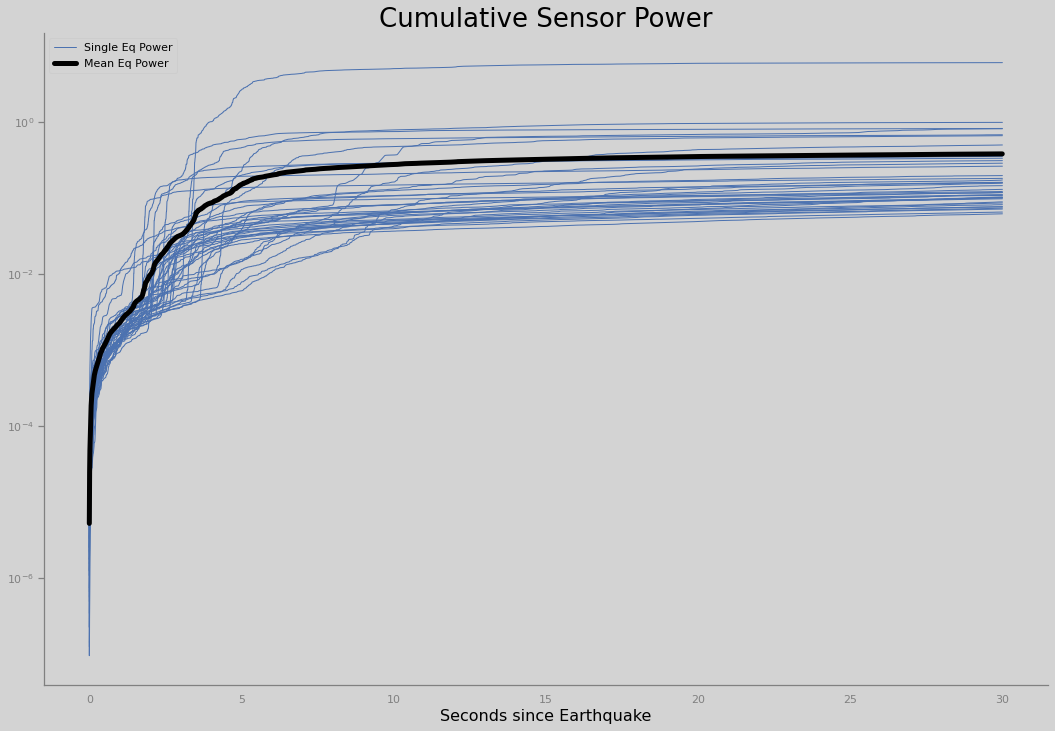

In [164]:
f, ax = plt.subplots(facecolor = 'lightgrey')

r = ss[0]
for i, s in enumerate(ss):
    if i != 0:
        r = r + s
        sns.lineplot(x = np.linspace(0, 30, len(s)), y = s, ax = ax, color = 'C0', linewidth = 1)
    else:
        sns.lineplot(x = np.linspace(0, 30, len(s)), y = s, ax = ax, color = 'C0', linewidth = 1, label = 'Single Eq Power')
r = r/len(ss)
sns.lineplot(x = np.linspace(0, 30, len(r)), y = r, ax = ax, color = 'black', linewidth = 5, label = 'Mean Eq Power')

# x = np.linspace(0,30, len(r[:-1]))
# y = r[:-1].values
# y = np.log(y)

# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import FunctionTransformer
# transformer = FunctionTransformer(np.log, validate=True)

# x_trans = transformer.fit_transform(x.reshape(-1,1))[1:]
# regressor = LinearRegression()
# results = regressor.fit(x_trans, y[1:])                # 2
# model = results.predict
# y_fit = model(x_trans)
# ax.plot(x[1:], np.exp(y_fit), "--", label="Fit", color = 'red')
plt.legend()
plt.yscale('log')
plt.title('Cumulative Sensor Power')
plt.xlabel('Seconds since Earthquake')
plt.savefig(join('/bsuhome/zacharykeskinen/infrasound/figures/energy', 'all_eq_energy.png'))

/bsuhome/zacharykeskinen/miniconda3/envs/infra/lib/python3.9/site-packages/sklearn/preprocessing/_function_transformer.py:292: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))


Text(0.5, 0, 'Seconds since Earthquake')

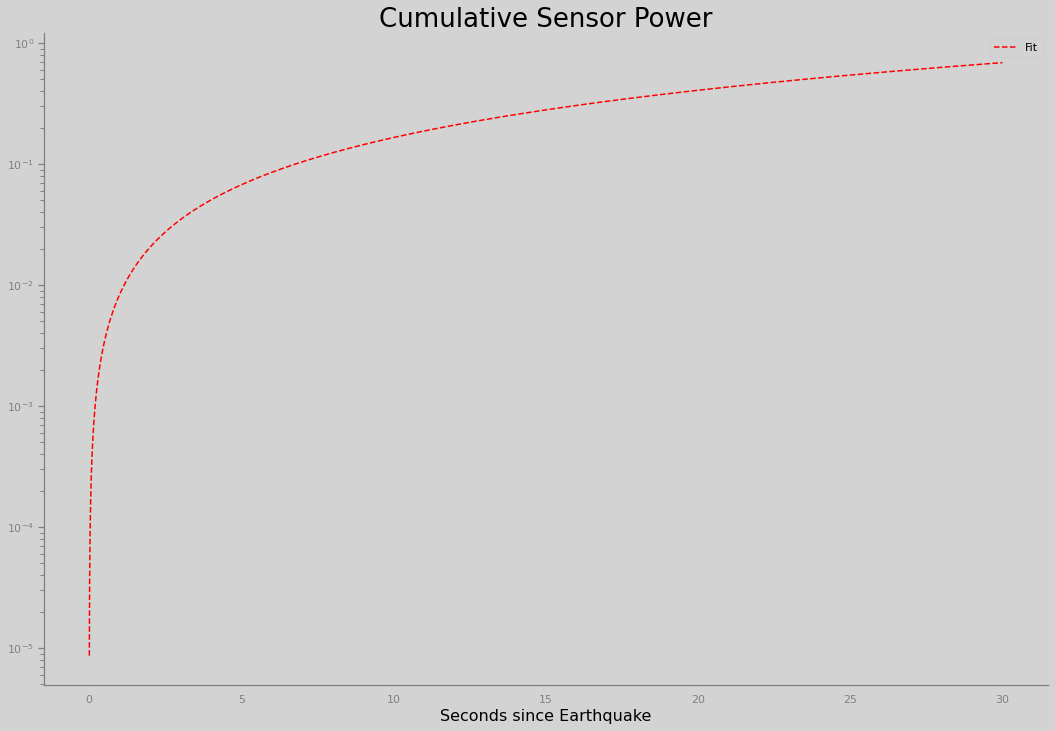

In [148]:
f,ax = plt.subplots()
x = np.linspace(0,30, len(r[:-1]))
y = r[:-1].values
y = np.log(y)

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log, validate=True)

x_trans = transformer.fit_transform(x.reshape(-1,1))[1:]
regressor = LinearRegression()
results = regressor.fit(x_trans, y[1:])                # 2
model = results.predict
y_fit = model(x_trans)
ax.plot(x[1:], np.exp(y_fit), "--", label="Fit", color = 'red')
plt.legend()
plt.yscale('log')
plt.title('Cumulative Sensor Power')
plt.xlabel('Seconds since Earthquake')

/bsuhome/zacharykeskinen/miniconda3/envs/infra/lib/python3.9/site-packages/sklearn/preprocessing/_function_transformer.py:292: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))


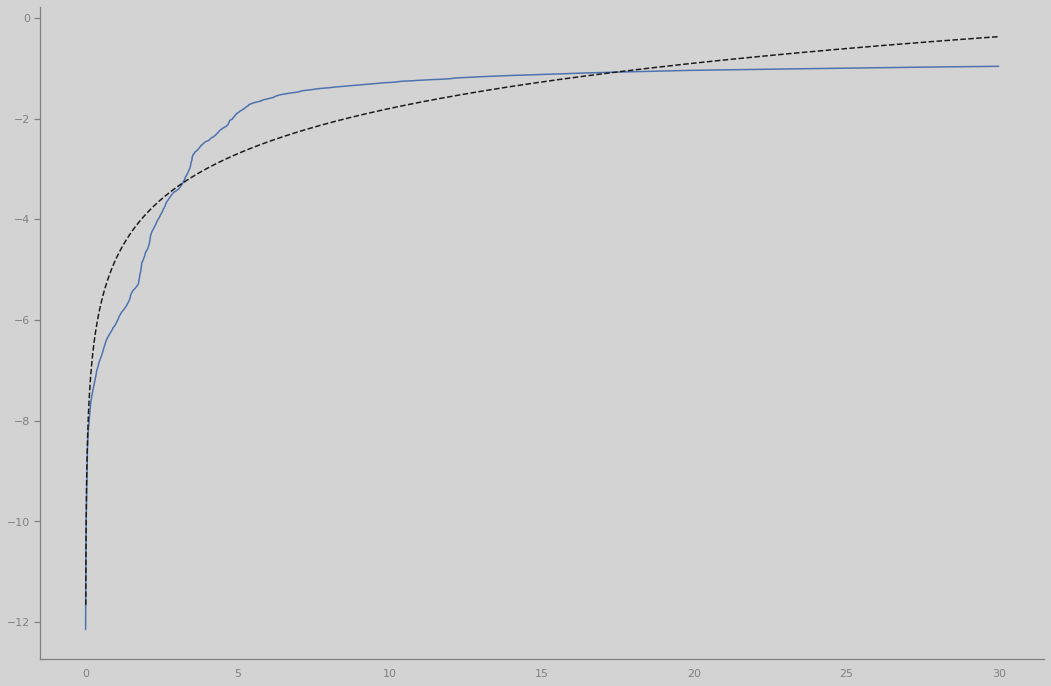

In [133]:
from scipy.optimize import curve_fit
x = np.linspace(0,30, len(r[:-1]))
y = r[:-1].values
y = np.log(y)
plt.plot(x,y)

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log, validate=True)

x_trans = transformer.fit_transform(x.reshape(-1,1))[1:]
regressor = LinearRegression()
results = regressor.fit(x_trans, y[1:])                # 2
model = results.predict
y_fit = model(x_trans)
plt.plot(x[1:], y_fit, "k--", label="Fit")
# plt.yscale('log')

In [119]:
np.concatenate((np.zeros(3), np.array([0,2,3,4,5])))

array([0., 0., 0., 0., 2., 3., 4., 5.])

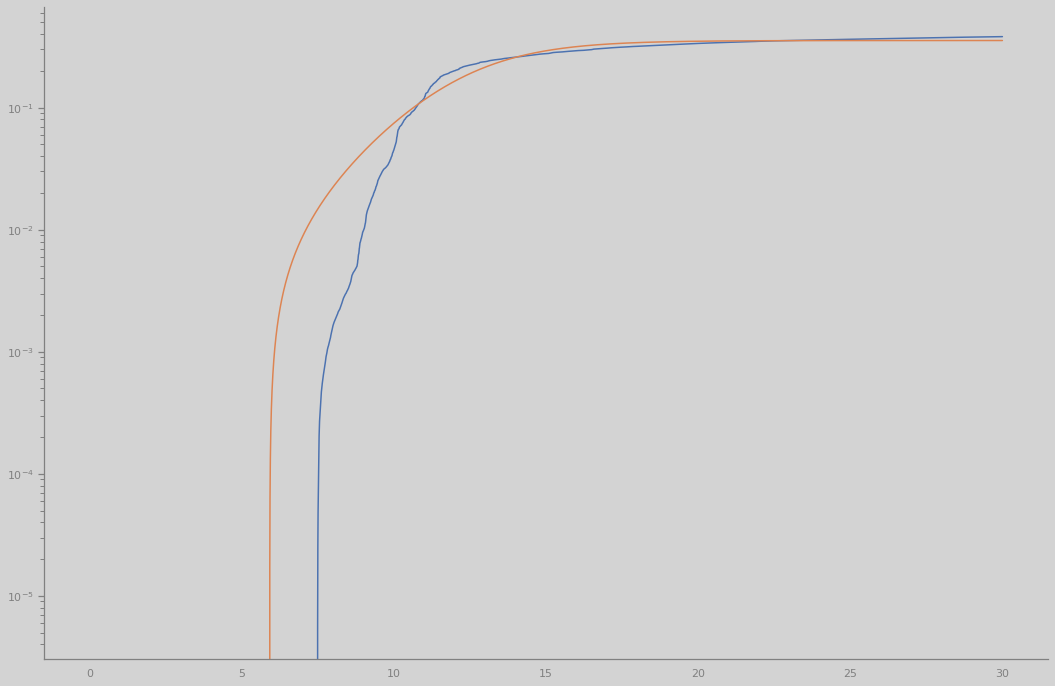

In [130]:
from scipy.optimize import curve_fit
ydata = r[:-1].values
ydata = np.concatenate((np.zeros(2000), ydata))
xdata = np.linspace(0,30, len(ydata))
plt.plot(xdata,ydata)

def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

p0 = [max(ydata), np.median(xdata), 1 ,min(ydata)] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox')
yest = sigmoid(xdata, *popt)
plt.plot(xdata, yest)
plt.yscale('log')